<a href="https://colab.research.google.com/github/alivahidi75/GANS/blob/main/TraditionalGAN_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mt
import matplotlib.pyplot as pt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import tensorflow as tf
import keras as ks
from keras import layers as lys
from keras import models as mls
from keras import initializers
from keras.utils import to_categorical as ct
import io
import gdown
import scipy.io

In [ ]:
class MonoGAN(ks.Model):
    def __init__(self, discriminator, generator, dimension):
        super(MonoGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.dimension = dimension

    def compile(self, dr_opt, gr_opt, loss_function):
        super(MonoGAN, self).compile()
        self.dr_opt = dr_opt
        self.gr_opt = gr_opt
        self.loss_function = loss_function

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        real_images = tf.cast(real_images, dtype=tf.float32)
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.dimension))

        generated_images = self.generator(random_latent_vectors)

        combined_images = tf.concat([generated_images, real_images], axis=0)

        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            dr_loss = self.loss_function(labels, predictions)

        grads = tape.gradient(dr_loss, self.discriminator.trainable_weights)
        self.dr_opt.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.dimension))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            gr_loss = self.loss_function(misleading_labels, predictions)

        grads = tape.gradient(gr_loss, self.generator.trainable_weights)
        self.gr_opt.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"dr_loss": dr_loss, "gr_loss": gr_loss}

In [ ]:
dimension = 7

dr = ks.Sequential(name="Discriminator")
dr.add(lys.Input(shape=(dimension,)))
dr.add(lys.Dense(units=180, activation='sigmoid',kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_initializer=initializers.Zeros()))
dr.add(lys.LeakyReLU(alpha=0.4))
dr.add(lys.Dense(units=140, activation='sigmoid',  kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_initializer=initializers.Zeros()))
dr.add(lys.LeakyReLU(alpha=0.4))
dr.add(lys.Dense(units=120, activation='sigmoid',  kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_initializer=initializers.Zeros()))
dr.add(lys.LeakyReLU(alpha=0.4))
dr.add(lys.Dropout(0.4))
dr.add(lys.Dense(1))
dr.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 180)                 │           1,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 180)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 140)                 │          25,340 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 140)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 120)                 │          16,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,821 (171.18 KB)

 Trainable params: 43,821 (171.18 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gr = ks.Sequential(name = "Generator")
gr.add(lys.Input(shape=(dimension,)))
gr.add(lys.Dense(180, activation='tanh', kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_initializer=initializers.Zeros()))
#gr.add(lys.LeakyReLU(alpha=0.4))
gr.add(lys.Dense(100, activation='tanh',kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_initializer=initializers.Zeros()))
#gr.add(lys.LeakyReLU(alpha=0.4))
gr.add(lys.Dense(7, activation='relu'))
gr.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 180)                 │           1,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 180)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │          18,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 7)                   │             707 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,247 (79.09 KB)

 Trainable params: 20,247 (79.09 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
file_id = "1Z_mEDB60-BnoKCEbiYqxKchk4NSgLcKW"
output_name = "downloaded_file.xlsx"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_name, quiet=False)
data = pd.read_excel(output_name)
data = data.to_numpy()

Downloading...
From: https://drive.google.com/uc?id=1Z_mEDB60-BnoKCEbiYqxKchk4NSgLcKW
To: /content/downloaded_file.xlsx
100%|██████████| 396k/396k [00:00<00:00, 44.7MB/s]


In [ ]:
input = data[:, 1:8]
output = data[:, 0]
output = output - 1

f = input.shape[1]
pca = PCA(n_components=7)
pca.fit(input)
input= pca.transform(input)
minmax = MinMaxScaler()
dataset =  minmax.fit_transform(input).astype(np.float32)
#dataset = normalizeData(input).astype(np.float32)  # Convert to float32
dataset = tf.data.Dataset.from_tensor_slices(dataset).batch(512)

Epoch 1/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - dr_loss: 0.7166 - gr_loss: 0.9844
Epoch 2/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - dr_loss: 0.6985 - gr_loss: 0.8623
Epoch 3/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - dr_loss: 0.6926 - gr_loss: 0.7921
Epoch 4/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - dr_loss: 0.6913 - gr_loss: 0.7605
Epoch 5/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - dr_loss: 0.6911 - gr_loss: 0.7497
Epoch 6/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - dr_loss: 0.6910 - gr_loss: 0.7469
Epoch 7/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - dr_loss: 0.6911 - gr_loss: 0.7459
Epoch 8/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - dr_loss: 0.6911 - gr_loss: 0.7453
Epoch 9/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - dr_loss: 0.6912 - gr_loss: 0.7453
Epoch 10/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - dr_loss: 0.6914 - gr_loss: 0.7450
Epoch 11/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - dr_loss: 0.6916 - gr_loss: 0.7448
Epoch 12/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s

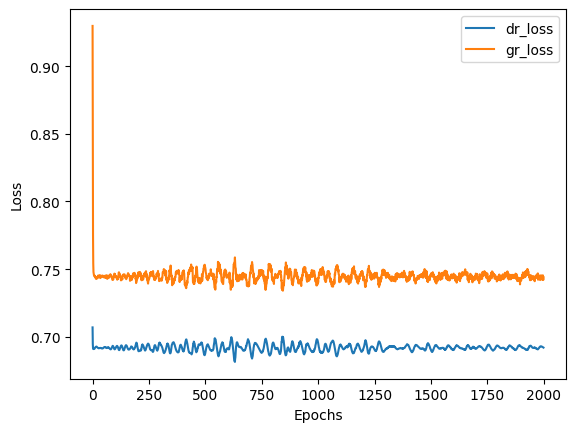

In [ ]:
gan = MonoGAN(dr, gr, dimension)
gan.compile(
  dr_opt=ks.optimizers.Adam(learning_rate= ks.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001,decay_steps=10000,decay_rate=0.5),beta_1=0.5),
  gr_opt=ks.optimizers.Adam(learning_rate= ks.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001,decay_steps=10000,decay_rate=0.5),beta_1=0.5),
  loss_function=ks.losses.BinaryCrossentropy(from_logits=True))

# Train the GAN
history = gan.fit(dataset,epochs=2000)
print(history.history.keys())
pt.plot(history.history['dr_loss'])
pt.plot(history.history['gr_loss'])
pt.ylabel('Loss')
pt.xlabel('Epochs')
pt.legend(['dr_loss','gr_loss'])
